The data source for this project is the National Transportation Safety Board Aviation Accident database available at 
https://app.ntsb.gov/avdata/Access/

This is a MS Access formated database composed of 20 tables. 

For the purpose of this project an initial subset of the data was filtered out of MS Access using that program's query utilities. This initial definition was meant to be broad in scope to make the dataset for the project more manageable.
This was done by avoiding to export columns that clearly would not contribute to the analysis of the problem and only selecting records pertinent to the project (i.e. commercial flight operations were left out of the export.)


The following tables were condensed and exported to csv files:
- aircraft: condensed from 93 to 34 columns and from 85337 records to 69071.
- crew_flt_time: condensed from 8 to 6 columns.
- crew: condensed from 33 to 17 columns.
- crew_ratings: condensed from 7 to 5 columns.
- events: condensed from 71 to 33 columns.
- findings: condensed from 13 to 11 columns.

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import missingno as msno
import matplotlib.pyplot as plt

In [2]:
def generate_profile(df):
    '''generate pandas profile'''
    
    profile = ProfileReport(df)
    profile.to_widgets()

# Aircraft Dataset

The aircraft dataset contains information on the aircraft involved in the accident. The column 'far_part' will be used to determine under what code the flight was operating. This is were the data can be filter to include only General Aviation records and exclude commercial aviation. The column 'second_pilot' will be use to filter the data to include only single pilot operations (scope of analysis). Other remaining fields may be useful in analysis.

In [3]:
file = 'D:/cap/capstone2/data/raw/aircraft.csv'
aircraft = pd.read_csv(file, encoding = 'Windows-1252', index_col = 0, low_memory = False)   
aircraft.head()

,Aircraft_Key,far_part,flt_plan_filed,flight_plan_activated,damage,acft_make,acft_model,fixed_retractable,acft_serial_no,cert_max_gr_wt,...,phase_flt_spec,afm_hrs_since,rwy_num,rwy_len,rwy_width,site_seeing,air_medical,med_type_flight,acft_year,ifr_equipped_cert
ev_id,,,,,,,,,,,,,,,,,,,,,
20051031X01758,1,91,NONE,NaN,SUBS,1200,G103,NaN,3603,1200.0,...,570.0,NaN,NaN,NaN,NaN,N,N,NaN,NaN,0
20001211X11538,1,129,UNK,NaN,UNK,,A330,NaN,,NaN,...,0.0,NaN,0,NaN,NaN,N,N,NaN,NaN,0
20020917X04814,1,91,NONE,NaN,SUBS,,HOBBS B8M,NaN,JOH1,550.0,...,560.0,NaN,20,3900.0,60.0,N,N,NaN,NaN,0
20020917X02887,1,91,NONE,NaN,DEST,,KR-2,NaN,13650715,900.0,...,570.0,NaN,0,0.0,0.0,N,N,NaN,NaN,0
20020917X03618,1,91,NONE,NaN,DEST,,MIDGET MUSTANG,NaN,411GH,1500.0,...,570.0,NaN,0,0.0,0.0,N,N,NaN,NaN,0


In [4]:
#initial profile
#generate_profile(aircraft)

An initial review of this dataset indicates several columns have a large number of missing values while others are not germane to the scope of the analysis. These columns will be dropped. 

In [5]:
# These columns have no usable data or are missing too many values to be of use
print(aircraft.shape)

ifr = aircraft[aircraft.ifr_equipped_cert != 0]
print(ifr.shape)

flt_plan = aircraft.flight_plan_activated.isnull().sum()
print(flt_plan)

# column has no usable data
aircraft.drop(columns=['ifr_equipped_cert', 'flight_plan_activated'], inplace=True)

(85337, 37)
(0, 37)
59792


In [6]:
#drop columns not applicable to analysis
to_drop = ['damage', 'acft_serial_no', 'cert_max_gr_wt', 'acft_category', 'homebuilt', 
           'type_last_insp', 'date_last_insp', 'afm_hrs_last_insp', 'acft_reg_cls', 'afm_hrs', 'dprt_pt_same_ev', 'dprt_apt_id',
           'dprt_time', 'dprt_timezn', 'dest_same_local', 'dest_apt_id', 'afm_hrs_since', 'rwy_num', 'rwy_len', 
           'rwy_width', 'site_seeing', 'air_medical', 'med_type_flight', 'acft_year']
           
aircraft.drop(columns = to_drop, inplace=True)
print(aircraft.columns)

Index(['Aircraft_Key', 'far_part', 'flt_plan_filed', 'acft_make', 'acft_model',
       'fixed_retractable', 'total_seats', 'num_eng', 'type_fly',
       'second_pilot', 'phase_flt_spec'],
      dtype='object')


In [7]:
print(len(aircraft))
aircraft.far_part.unique()

85337


array(['91', '129', 'UNK ', '137', 'NUSN', nan, '135', 'NUSC', 'PUBU',
       '121', '133', '103', '091F', 'ARMF', '125', '091K', '107', '437'],
      dtype=object)

Categorical values for operational code (far_part) are consistent.

Task: Filter dataset by 'far_part' column to retain only non-commercial aviation cases.

Retained records: 091, 091F, 091K - General Aviation
                  103             - Ultralight aircraft
                  UNK             - to check if record is GA by other means

In [23]:
aircraft_ga = aircraft[aircraft['far_part'].isin(['91', '091F', '091K', '103', 'UNK'])]
print(aircraft_ga.shape)
aircraft_ga.far_part.unique()

(68705, 11)


array(['91', '103', '091F', '091K'], dtype=object)

Column 'second_pilot' indicates whether flight was conducted by a single pilot or crew. The scope of this analysis is limited to single pilot operations. Will discard records indicating a second pilot was present. Will retain null entries and those markes as 'U' (unknown) and will attempt to derive its value indirectly. 

Task: Filter dataset to include only single pilot operations.

### Task: cleanup flt_plan_file column

Aicraft may operate under Visual Flight rules (VFR), Instrument flight rules (IFR) or a combination of both (VFIF).

Simplifly categories - condense MVFR and CVFR under VFR flight plans.

In [24]:
aircraft_ga['flt_plan_filed'] = aircraft_ga['flt_plan_filed'].str.strip()
print(aircraft_ga['flt_plan_filed'] .unique())
print(aircraft_ga['flt_plan_filed'] .value_counts())

['NONE' 'VFR' 'IFR' 'UNK' 'CVFR' nan 'VFIF' 'MVFR']
NONE    54786
IFR      5781
VFR      5010
UNK      1333
CVFR     1286
VFIF      141
MVFR       48
Name: flt_plan_filed, dtype: int64


<ipython-input-24-574fa783d75b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aircraft_ga['flt_plan_filed'] = aircraft_ga['flt_plan_filed'].str.strip()


In [25]:
aircraft_ga['flt_plan_filed'].fillna('UNK', inplace=True)
aircraft_ga['flt_plan_filed'] = aircraft_ga['flt_plan_filed'].replace(['MVFR', 'CVFR'], 'VFR')
print(aircraft_ga['flt_plan_filed'] .unique())
print(aircraft_ga['flt_plan_filed'] .value_counts())

['NONE' 'VFR' 'IFR' 'UNK' 'VFIF']
NONE    54786
VFR      6344
IFR      5781
UNK      1653
VFIF      141
Name: flt_plan_filed, dtype: int64


D:\Anaconda\envs\Capstone2\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-25-82e463b908dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aircraft_ga['flt_plan_filed'] = aircraft_ga['flt_plan_filed'].replace(['MVFR', 'CVFR'], 'VFR')


In [11]:
aircraft_ga_single = aircraft_ga[aircraft_ga['second_pilot'] != 'Y']
print(aircraft_ga_single['second_pilot'].unique())
print(aircraft_ga_single.shape)

['N' nan 'U']
(59482, 11)


In [12]:
print(aircraft_ga_single['phase_flt_spec'].unique())

[570. 560. 520.  nan   0. 522. 571. 565. 572. 580. 513. 540. 541. 530.
 550. 500. 553. 523. 564. 573. 610. 521. 574. 576. 510. 600. 568. 531.
 502. 582. 581. 563. 514. 590. 591. 551. 575. 512. 503. 561. 583. 566.
 504. 552. 562. 567. 569. 592. 505. 501. 400. 250. 542.]


Phase of flight is categorical data inputed as codes. 

Task: Map descriptibe text to categorical codes for column 'phase_flt_spec" to improve readability.

In [13]:
aircraft_ga_single['phase_flt_spec'].fillna(0, inplace=True)
aircraft_ga_single['phase_flt_spec'].astype(int)

phase_codes = {500:'Standing', 501:'Standing - pre-flight', 502: 'Standing - starting engine(s)', 
               503: 'Standing - engine(s) operating', 504:'Standing - engine(s) not operating',
               505: 'Standing - idling rotors', 510: 'Taxi', 511: 'Taxi - pushback/tow', 512: 'Taxi - to takeoff',
               513: 'Taxi - from landing', 514: 'Taxi - aerial', 520:'Takeoff', 521: 'Takeoff - roll/run',
               522: 'Takeoff - initial climb', 523: 'Takeoff - aborted', 530: 'Climb', 531: 'Climb - to cruise',
               540: 'Cruise', 541: 'Cruise - normal', 542: 'Maneuvering - holding (IFR)', 550: 'Descent',
               551: 'Descent - normal', 552: 'Descent - emergency', 553: 'Descent - uncontrolled', 560: 'Approach',
               561: 'Approach - VFR pattern - downwind', 562: 'Approach - VFR pattern - turn to base', 
               563: 'Approach - VFR pattern - base leg/base to final', 564: 'Approach - VFR pattern - final approach',
               565: 'Go-around (VFR)', 566: 'Approach - Initial approach fix (IAF) to final approach fix (FAF)/outer marker (IFR)',
               567: 'Approach - final approach fix (FAF)/outer marker to threshold (IFR)',
               568: 'Approach - circling (IFR)', 569: 'Missed approach (IFR)', 570: 'Landing', 571: 'Landing - flare/touchdown',
               572: 'Landing - roll', 573: 'Landing - aborted', 574: 'Emergency landing', 575: 'Emergency landing after takeoff',
               576: 'Emergency descent/landing', 580: 'Maneuvering', 581: 'Maneuvering - aerial application', 
               582: 'Maneuvering - turn to reverse direction', 583: 'Maneuvering - turn to landing area (emergency)',
               590: 'Hover', 591: 'Hover - in ground effect', 592: 'Hover - out of ground effect', 600: 'Other', 610:'Unknown',
               0: None}

aircraft_ga_single['phase_flt_spec'] = aircraft_ga_single['phase_flt_spec'].map(phase_codes)
print(aircraft_ga_single['phase_flt_spec'].unique())

['Landing' 'Approach' 'Takeoff' None 'Takeoff - initial climb'
 'Landing - flare/touchdown' 'Go-around (VFR)' 'Landing - roll'
 'Maneuvering' 'Taxi - from landing' 'Cruise' 'Cruise - normal' 'Climb'
 'Descent' 'Standing' 'Descent - uncontrolled' 'Takeoff - aborted'
 'Approach - VFR pattern - final approach' 'Landing - aborted' 'Unknown'
 'Takeoff - roll/run' 'Emergency landing' 'Emergency descent/landing'
 'Taxi' 'Other' 'Approach - circling (IFR)' 'Climb - to cruise'
 'Standing - starting engine(s)' 'Maneuvering - turn to reverse direction'
 'Maneuvering - aerial application'
 'Approach - VFR pattern - base leg/base to final' 'Taxi - aerial' 'Hover'
 'Hover - in ground effect' 'Descent - normal'
 'Emergency landing after takeoff' 'Taxi - to takeoff'
 'Standing - engine(s) operating' 'Approach - VFR pattern - downwind'
 'Maneuvering - turn to landing area (emergency)'
 'Approach - Initial approach fix (IAF) to final approach fix (FAF)/outer marker (IFR)'
 'Standing - engine(s) not oper

D:\Anaconda\envs\Capstone2\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-13-2855c7eb398a>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aircraft_ga_single['phase_flt_spec'] = aircraft_ga_single['phase_flt_spec'].map(phase_codes)


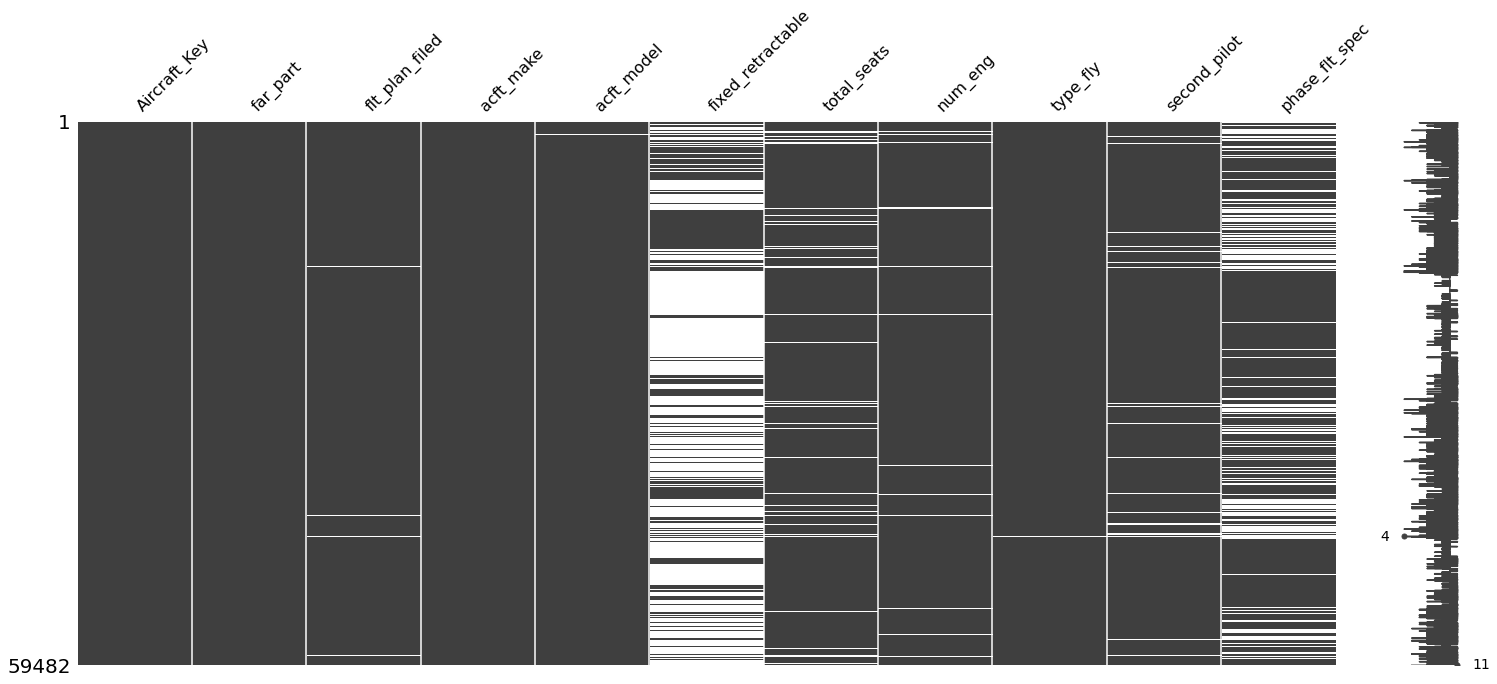

In [14]:
msno.matrix(aircraft_ga_single)
plt.show()

##### aircraft dataset current state:

- 'fixed_retractable' column is missing 65% of its values. It is possible to derive this information from the aircraf make and model. However, given that the analysis is to model pilot information to accidents this information is not critical. If aircraft complexity wants to be evaluated (a retractable gear is an indicator of a complex aircraft) in the future this information can be filled in. 

- 'Second_pilot' is missing about 4% of its data. As the analysis concentrates on single pilot operations, it is important to try to derive the missing entries from other tables.

- 'phase_flt_spec' is missing 26% of values. It is yet to be determined if this column is needed for modeling. Will attempt to derive missing values.





### Import additional datasets

The filtered aircraft_ga_single dataframe index will serve as the anchor to merge the additional datasets. In this way only applicable records - General Aviation and Single (or unknown) pilot(s) -  will be merged.

### Merge Crew Dataset

In [15]:
file = 'D:/cap/capstone2/data/raw/crew.csv'
crew = pd.read_csv(file, encoding = 'Windows-1252', index_col = 0, low_memory = False) 

In [16]:
aircraft_crew = pd.merge(aircraft_ga_single, crew, on = 'ev_id', how = 'left' )

Task: Analyse 'Crew Category" column and filter out unwanted records

In [17]:
print(aircraft_crew['crew_category'].unique())
aircraft_crew.shape

['PLT  ' 'DSTU ' 'FLTI ' nan 'PASS ' 'OTHR ' 'KPLT ' 'PRPS ' 'CPLT '
 'CABN ' 'FENG ']


(62355, 27)

In [18]:
#filter out unwanted pilot categories - retain pilot, student, and empty

aircraft_crew = aircraft_crew[~aircraft_crew['crew_category'].isin(['FLTI ', 'PASS ', 'OTHR ', 'KPLT ', 'PRPS ', 'CPLT ', 'CABN ', 'FENG '])]
print(aircraft_crew['crew_category'].unique())

['PLT  ' 'DSTU ' nan]


In [19]:
aircraft_crew['crew_category'].fillna('unkn', inplace=True)
aircraft_crew['crew_category'] = aircraft_crew['crew_category'].str.strip()
aircraft_crew['crew_category'] = aircraft_crew['crew_category'].replace(['PLT', 'DSTU'], ['pilot','student'])
print(aircraft_crew['crew_category'].unique())

['pilot' 'student' 'unkn']


Task: eliminate records containing more than one crew pilot based on crew_number column

In [20]:
print(aircraft_crew['crew_no'] .unique())

aircraft_crew['crew_no'].fillna(0, inplace=True)
aircraft_crew['crew_no'].astype(int)
print(aircraft_crew['crew_no'] .unique())
print(aircraft_crew['crew_no'] .value_counts())

[ 1.  2. nan  3.  4.  5.]
[1. 2. 0. 3. 4. 5.]
1.0    60371
2.0      385
0.0      136
3.0       11
5.0        2
4.0        2
Name: crew_no, dtype: int64


In [21]:
multi_crew = aircraft_crew[aircraft_crew['crew_no'] > 1]
aircraft_crew = aircraft_crew[~aircraft_crew.crew_no.isin(multi_crew.crew_no)]

print(aircraft_crew['crew_no'] .unique())
print(aircraft_crew['crew_no'] .value_counts())

[1. 0.]
1.0    60371
0.0      136
Name: crew_no, dtype: int64


In [22]:
#initial profile
#generate_profile(aircraft_crew)

Initial look at missing values:
   - Crew age is missing 6% of values. Missing values could be approximated by applying median age with flight hours as the determining variable (higher flight hours usually mean a more experienced and older pilot.)
   - crew sex is missing 7% of values. Will attempt to derive missing values in proportion to resulting dataset once filtered for non-commercial operations.
   - Crew country of recidence is missing 57% of values. USA recidence can be derived from State of Recidence information. For our analysis, couuntry of recidence can be simplified to two categories (USA vs. Non-USA.)
   - Crew injury level is missing 58% of values. Will attempt to derive data from accident type i.e. incident vs accident where incidents are always non-fatal and event narratives.
   - biannual flight review (bfr) and bfr_date appear to be missing values in a complementary fashion. biannual flight review data can be derived by referencing bfr_date (if bfr_date is within valid range from completion to date of incident the bfr column should indicate 'Y')